In [1]:
cd /home

/home


# Results experiments

###### by Cristobal Donoso-Oliva et.al., 2022

In [2]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import pandas as pd
import numpy as np
import tomli
import os 

from presentation.pipeline.base import load_pt_data, compile_astromer
from src.models.zero import get_ASTROMER
from src.utils import get_metrics

%load_ext autoreload
%autoreload 2

os.environ["CUDA_VISIBLE_DEVICES"] = "3" # 

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

plt.style.use('dark_background')

In [17]:
def collect_metrics(config_files_folder, classification=False, cases=['a', 'b']):
    '''
    Concatenate dataframes containing testing/validation metrics.
    It assumes a fixed structure:
    '<path of the experiments>/<science_case>/config_file.toml'
    '''
    metrics_list = []
    for sci_case in cases:
        config_files = f'{config_files_folder}/{sci_case}/'
        for file in os.listdir(config_files):
            sample_per_class = file.split('_')[0]
            fold_n = file.split('_')[-1].split('.')[0]
            
            current = os.path.join(config_files, file)
            with open(current, mode="rb") as fp:
                config = tomli.load(fp)
            
            if classification:
                metrics = pd.read_csv(os.path.join(config['classification']['exp_path'], 'metrics.csv'))
                metrics['fold'] = [fold_n]*metrics.shape[0]
                metrics['spc']  = [sample_per_class]*metrics.shape[0]
                metrics['case']  = [sci_case]*metrics.shape[0]
                metrics_list.append(metrics)
            else:
                metrics = pd.read_csv(os.path.join(config['finetuning']['exp_path'], 'metrics.csv'))
                metrics['fold'] = [fold_n]*metrics.shape[0]
                metrics['spc']  = [sample_per_class]*metrics.shape[0]
                metrics['case']  = [sci_case]*metrics.shape[0]
                metrics_list.append(metrics)
            

    return pd.concat(metrics_list)

## Pretraining results

First we take an arbitrary config file from the `experiments_config_files` folder

In [5]:
experiments_config_files = './presentation/pipeline/config/alcock/'

We open the config file to see the used pretraining weights

In [6]:
with open(os.path.join(experiments_config_files,'a','100_0.toml'), mode="rb") as fp:
    config = tomli.load(fp)
config['finetuning']['weights']

'./weights/rf_macho'

In [60]:
pd.read_csv(os.path.join(config['pretraining']['data']['path'], 'objects.csv')).sum()

label    CBDBDubiousMiraOtherPulse
size                       3775937
dtype: object

In [61]:
config['pretraining']['data']['sampling'] = False

In [62]:
data = load_pt_data(config, subsets=['test'], step='pretraining')

[INFO] Loading data from ./data/records/big_atlas


In [46]:
d_model = config['astromer']['head_dim']*config['astromer']['heads']
astromer =  get_ASTROMER(num_layers=config['astromer']['layers'],
                         d_model=d_model,
                         num_heads=config['astromer']['heads'],
                         dff=config['astromer']['dff'],
                         base=config['positional']['base'],
                         dropout=config['astromer']['dropout'],
                         maxlen=config['astromer']['window_size'],
                         no_train=False)
astromer = compile_astromer(config, astromer, step='finetuning')

[INFO] Using custom scheduler
[INFO] Pretrained weights: ./weights/rf_macho


In [47]:
%%time
loss, r2 = astromer.evaluate(data['test'])

     30/Unknown - 4s 104ms/step - loss: 0.1471 - r_square: 0.8004WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


KeyboardInterrupt: 

In [23]:
config['finetuning']['weights'], loss

('./weights/rf_macho', 0.1383729726076126)

0.14907151
0.1484441
0.70052946
0.70354795


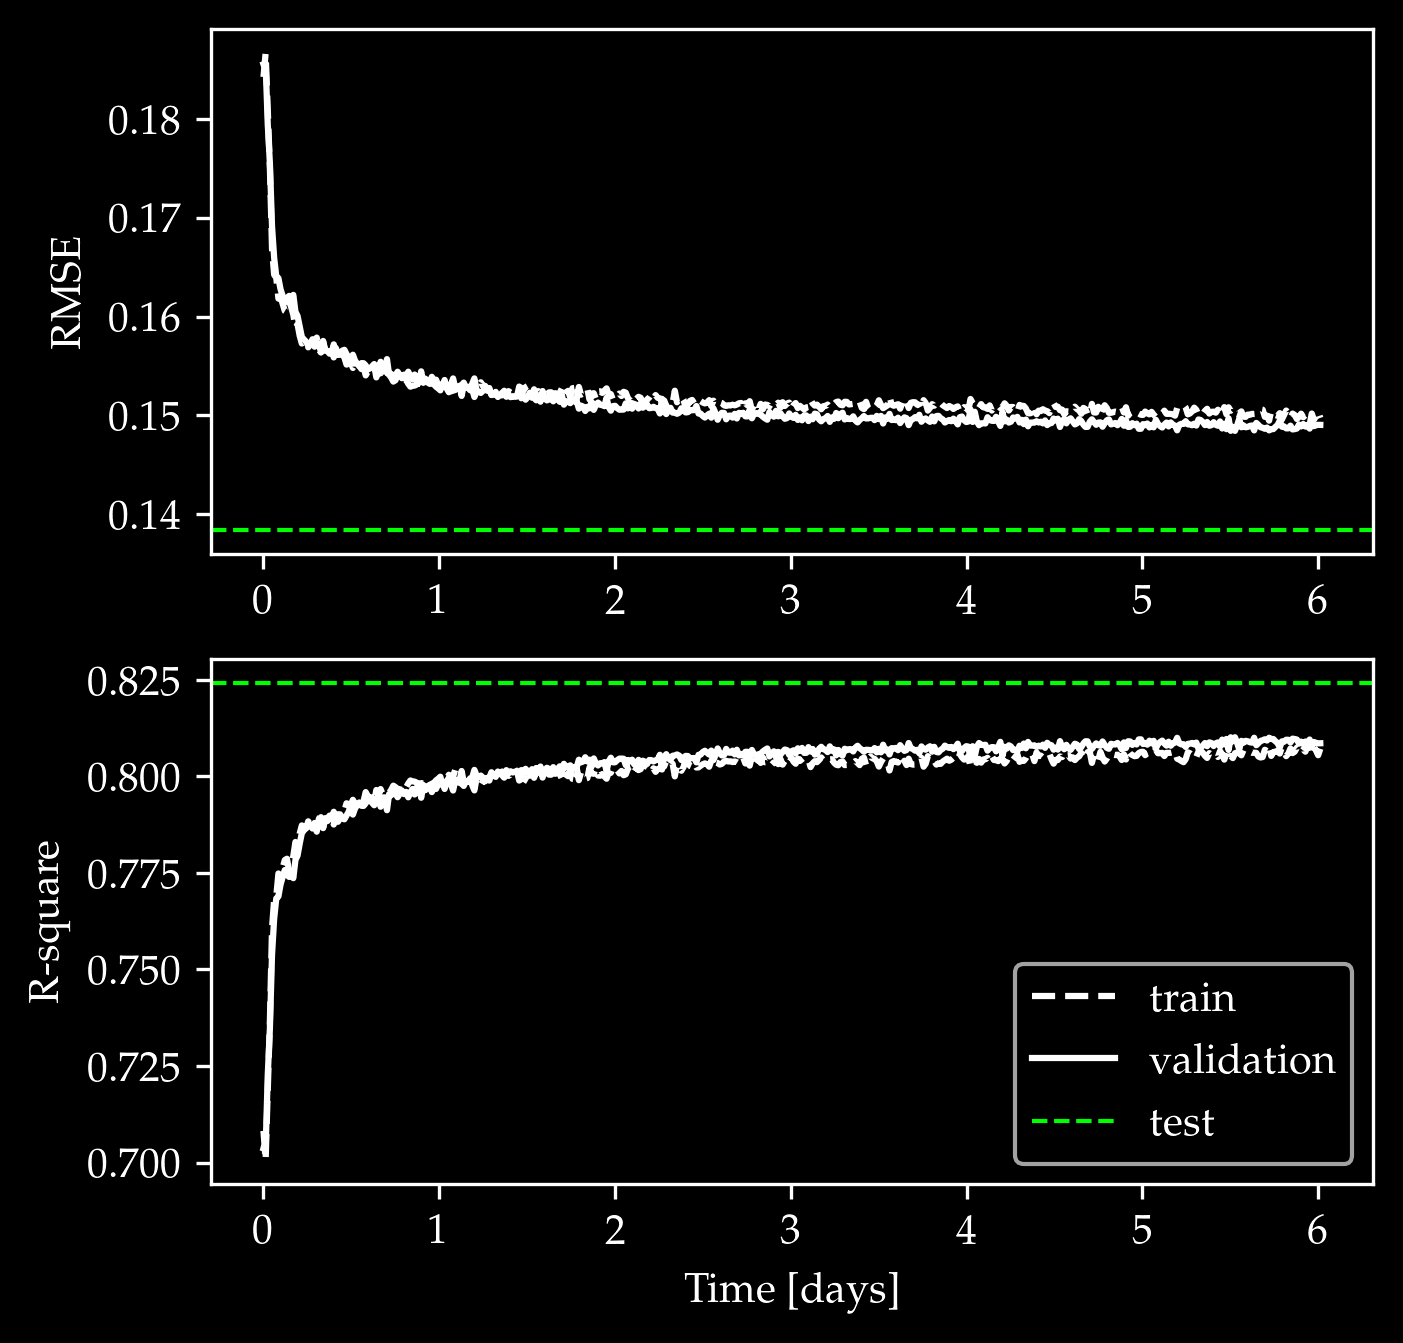

In [31]:
fig, axes = plt.subplots(2,1, figsize=(5,5), dpi=300)
for k, (metric, test_value) in enumerate(zip(['epoch_loss', 'epoch_r_square'], 
                               [loss, r2])):
    for ls, subset in zip(['--', '-'],['train', 'validation']):
        df = get_metrics(os.path.join('./results/macho_rf', 'logs', subset),
                         show_keys=False, metric_name=metric, full_logs=True)
        print(df['value'].min())
        df['time'] = ((df['wall_time'] - df['wall_time'].iloc[0])/3600)/24 
        axes[k].plot(df['time'], df['value'], color='white', linestyle=ls, label=subset)
    
    axes[k].axhline(y=test_value, color='lime', linestyle='--', linewidth=1, label='test')
    
    if k == 0:
#         axes[k].set_yscale('log')
        axes[k].set_ylabel('RMSE')
    else:
        axes[k].set_ylabel('R-square')
        axes[k].set_xlabel('Time [days]')
        axes[k].legend()

## Finetuning results

Use `collect_metrics` to join all the metrics associated with the experiments in 
`./presentation/pipeline/config/<experiment>`

By default it gives **finetuning** metrics. Use `clasification=True` for getting classification metrics 

In [7]:
metrics_ft = collect_metrics(experiments_config_files)

In [8]:
metrics_ft.groupby('case').mean()

,rmse,r_square
case,,
a,0.111027,0.792734
b,0.111027,0.792734


## Metrics by number of samples per class

Defining plot styles for the classifiers

In [9]:
styles = {'MLP+ATT':{'marker':'^', 'linestyle':'--'}, 
          'LSTM+ATT':{'marker':'o', 'linestyle':'-'}, 
          'Baseline':{'marker':'s', 'linestyle':':'}}

In [10]:
selected_metric = 'f1'

Text(0.51, -0.02, 'Samples per class')

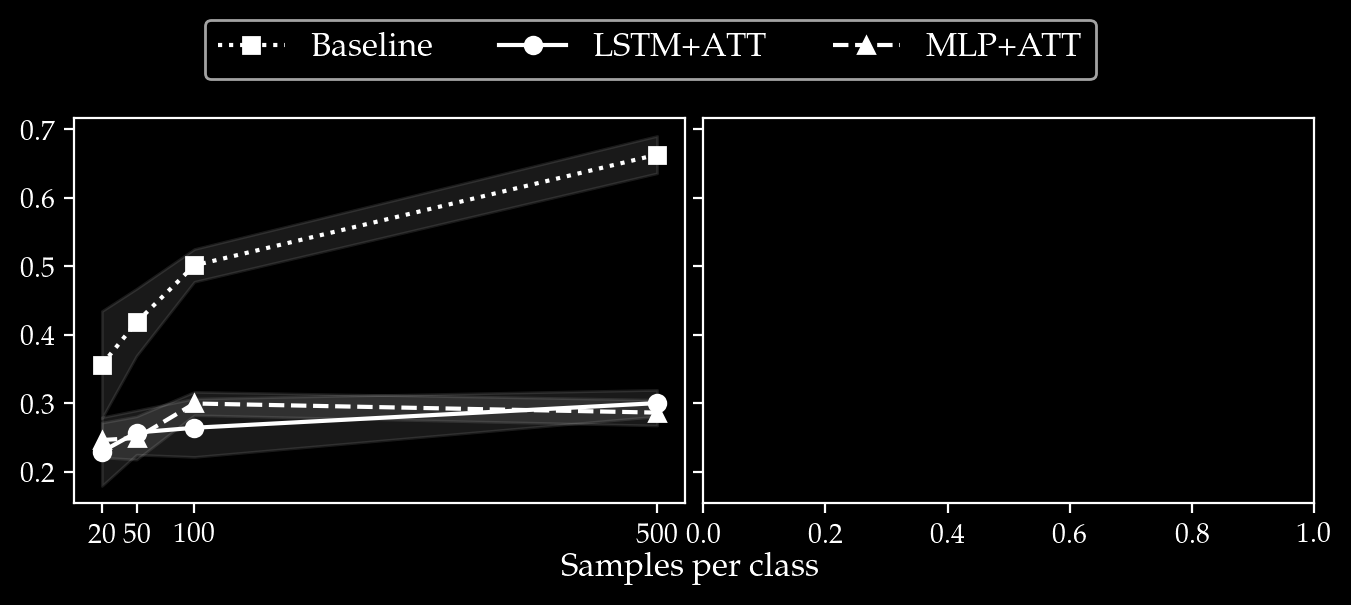

In [20]:
fig, axes = plt.subplots(1,2, figsize=(8,2.5), 
                         gridspec_kw={'hspace': 0.1, 'wspace': 0.03},
                         sharey=True, dpi=200)

for row, dataset_name in enumerate(['atlas']):
    experiments_config_files = './presentation/pipeline/config/{}'.format(dataset_name)
    
    metrics = collect_metrics(experiments_config_files, classification=True, cases=['a'])
    metrics = metrics.replace({'mlp_att':'MLP+ATT', 'lstm_att':'LSTM+ATT', 'lstm':'Baseline'})
    
    metrics_by_case = metrics.groupby('case')

    for col, (sci_case, frame_0) in enumerate(metrics_by_case):
        metrics_by_model = frame_0.groupby('model')

        for model_name, frame_1 in metrics_by_model:
            metrics_by_spc = frame_1.groupby('spc')

            model_metrics = []
            for spc, frame_2 in metrics_by_spc:
                mean = frame_2[selected_metric].astype(float).mean()
                std = frame_2[selected_metric].astype(float).std()
                model_metrics.append((float(spc), mean, std))

            sorted_metrics = sorted(model_metrics, key=lambda tup: tup[0])
            sorted_metrics = np.vstack(sorted_metrics)

            axes[col].plot(sorted_metrics[:, 0], 
                             sorted_metrics[:, 1], 
                             marker=styles[model_name]['marker'], 
                             color='w',
                             linestyle=styles[model_name]['linestyle'],
                             label=model_name)
            axes[col].fill_between(sorted_metrics[:, 0], 
                                     sorted_metrics[:, 1]+sorted_metrics[:, 2], 
                                     sorted_metrics[:, 1]-sorted_metrics[:, 2],
                                     color='w', alpha=0.1)

            axes[col].set_xticks(sorted_metrics[:, 0])
    #         axes[index].set_xscale('log')


        if col == 1:
            ax2 = axes[col].twinx()     
            ax2.set_yticks([])
            ax2.set_ylabel('MACHO')

    
axes[0].legend(ncol=3, bbox_to_anchor = (1.7, 1.3), fontsize=12)
if selected_metric == 'acc':
    axes[0].set_ylabel('Accuracy', fontsize=12)


fig.text(0.51, -0.02, 'Samples per class', ha='center', va='center', fontsize=12)